# 🏗️ Step 1: Download REIT Stock Data

In [80]:
# ─── Step 1: Download REIT Stock Data ────────────────────────
import yfinance as yf
import pandas as pd
import os

# 准备文件夹
data_path = "data"
os.makedirs(data_path, exist_ok=True)

# 股票列表和时间区间
tickers    = ['PLD', 'SPG', 'O']
start_date = '2020-01-01'
end_date   = '2024-01-01'

for ticker in tickers:
    stock = yf.download(ticker, start=start_date, end=end_date)

    # ── 关键改变在这里 ──
    # 1) 把索引 Date 还原为一列；2) 不输出索引
    stock.reset_index().to_csv(
        os.path.join(data_path, f"{ticker}.csv"),
        index=False
    )

    print(f"{ticker} data saved.")

/var/folders/dk/x1l2056s3cj0f19rptc_f3nr0000gn/T/ipykernel_43301/4243036567.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/dk/x1l2056s3cj0f19rptc_f3nr0000gn/T/ipykernel_43301/4243036567.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/dk/x1l2056s3cj0f19rptc_f3nr0000gn/T/ipykernel_43301/4243036567.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

PLD data saved.
SPG data saved.
O data saved.


In [81]:
!head -n 2 data/PLD.csv

Date,Close,High,Low,Open,Volume
,PLD,PLD,PLD,PLD,PLD


In [82]:
# ─── Step 2: Eligibility Check ─────────────────────────────
import pandas as pd

# 筛选参数
min_price_growth = 0.05      # 最低涨幅 5%
min_avg_volume   = 1_000_000 # 最低平均成交量 1,000,000

company_info = {
    'PLD': {'market_cap': 112e9, 'name': 'Prologis'},
    'SPG': {'market_cap':  38e9, 'name': 'Simon Property Group'},
    'O'  : {'market_cap':  43e9, 'name': 'Realty Income'}
}

eligible_companies = []

for ticker in tickers:
    # 1) 直接读取扁平 CSV
    df = pd.read_csv(f"data/{ticker}.csv", parse_dates=['Date'])
    df = df.set_index('Date')

    # 2) 确保数值型
    df['Close']  = pd.to_numeric(df['Close'],  errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

    # 3) 丢弃空值
    df = df.dropna(subset=['Close','Volume'])
    if df.empty:
        print(f"⚠️ {ticker} 数据为空，跳过")
        continue

    # 4) 计算涨幅 & 平均成交量
    price_growth = df['Close'].iloc[-1] / df['Close'].iloc[0] - 1
    avg_volume   = df['Volume'].mean()

    # 5) 打印参考
    cap = company_info[ticker]['market_cap'] / 1e9
    print(f"{ticker} | 市值：{cap:.0f} B | 涨幅：{price_growth:.2%} | 平均成交量：{avg_volume:,.0f}")

    # 6) 筛选
    if price_growth >= min_price_growth and avg_volume >= min_avg_volume:
        eligible_companies.append(ticker)

print("\n✅ Eligible companies:", eligible_companies)

PLD | 市值：112 B | 涨幅：66.48% | 平均成交量：3,232,579
SPG | 市值：38 B | 涨幅：24.44% | 平均成交量：3,067,743
O | 市值：43 B | 涨幅：-1.57% | 平均成交量：3,916,386

✅ Eligible companies: ['PLD', 'SPG']


In [83]:
!pip install matplotlib

/var/folders/dk/x1l2056s3cj0f19rptc_f3nr0000gn/T/ipykernel_43301/3978191218.py:36: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/x1l2056s3cj0f19rptc_f3nr0000gn/T/ipykernel_43301/3978191218.py:36: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/x1l2056s3cj0f19rptc_f3nr0000gn/T/ipykernel_43301/3978191218.py:36: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/x1l2056s3cj0f19rptc_f3nr0000gn/T/ipykernel_43301/3978191218.py:36: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/x1l2056s3cj0f19rptc_f3nr0000gn/T/ipykernel_43301/3978191218.py:36: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dk/x1l2

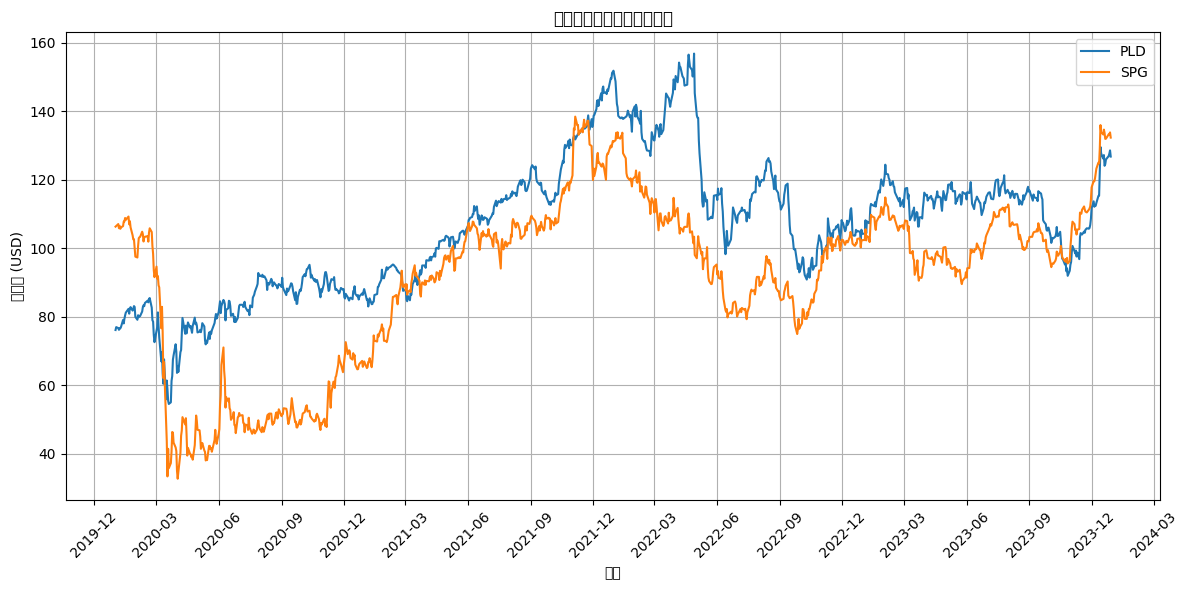

In [84]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 之前筛选出的合格 ticker 列表
eligible = ['PLD', 'SPG']

plt.figure(figsize=(12, 6))

for ticker in eligible:
    file_path = f"data/{ticker}.csv"

    # 跳过第二行 header，再读 Date/Close 两列
    df = pd.read_csv(
        file_path,
        skiprows=[1],                # 跳过第二行的重复表头
        usecols=['Date', 'Close'],   # 只读日期和收盘价
        parse_dates=['Date'],        # 把 Date 解析成 datetime
        index_col='Date'             # 并设为索引
    )

    plt.plot(df['Close'], label=ticker)

# 把 X 轴每三个月打一个大刻度
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

plt.title("符合条件股票的收盘价走势")
plt.xlabel("日期")
plt.ylabel("收盘价 (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()